In [1]:
#!pip3 install lightgbm

In [2]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

# The Snowflake Connector library.
import snowflake.connector as snow
from snowflake.connector.pandas_tools import write_pandas

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

C:\Users\nisar\New folder\lib\site-packages\snowflake\connector\options.py:94: UserWarning: You have an incompatible version of 'pyarrow' installed (6.0.1), please install a version that adheres to: 'pyarrow<5.1.0,>=5.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [3]:
train= pd.read_csv(r'C:\Users\nisar\Downloads\ADMProj\IFDtrain.csv',parse_dates=['Transaction_date'])
test= pd.read_csv(r'C:\Users\nisar\Downloads\ADMProj\IFDtest.csv',parse_dates=['Transaction_date'])
tr_df=train

In [4]:
## Phase I: Truncate/Delete the current data in the table
# The connector...
conn = snow.connect(user="pranaliv95",
   password="Pranaliv@95",
   account="yv43311.us-east-2.aws",
   # (the prefix in your snowflake space... for example, 
   # company.snowflakecomputing.com would just be "company" as the ACCOUNT name)
   #warehouse="WAREHOUSE",
   database="BOOK_RECOMMENDATION",
   schema="PUBLIC")

# Create a cursor object.
cur = conn.cursor()

sql = "USE ROLE SYSADMIN"
cur.execute(sql)

# And then use it.
sql = "USE DATABASE BOOK_RECOMMENDATION"
cur.execute(sql)

# And then use it.
sql = "USE SCHEMA PUBLIC"
cur.execute(sql)


In [5]:
cur = conn.cursor()
sql = "select * from IFDTRAIN"
cur.execute(sql)
 
train = cur.fetch_pandas_all()
 
train

,STORE_ID,BOOK_ID,TRANSACTION_DATE,SALES
0,1,2767052,2013-07-19,3
1,6,2767052,2013-07-26,34
2,5,2767052,2013-07-29,1
3,3,2767052,2013-08-09,6
4,10,2767052,2013-08-11,4
...,...,...,...,...
18811,9,236093,2014-09-14,30
18812,8,236093,2014-09-20,10
18813,6,236093,2014-10-03,21
18814,6,236093,2014-10-10,13


In [6]:
train.head()

,STORE_ID,BOOK_ID,TRANSACTION_DATE,SALES
0,1,2767052,2013-07-19,3
1,6,2767052,2013-07-26,34
2,5,2767052,2013-07-29,1
3,3,2767052,2013-08-09,6
4,10,2767052,2013-08-11,4


In [7]:
cur = conn.cursor()
sql = "select * from IFDTEST"
cur.execute(sql)
 
test = cur.fetch_pandas_all()
 
test

,ID,STORE_ID,BOOK_ID,TRANSACTION_DATE
0,80000,10,236093,2014-10-23
1,80001,9,236093,2014-10-25
2,80002,8,236093,2014-11-02
3,80003,2,236093,2014-11-08
4,80004,3,236093,2014-11-21
...,...,...,...,...
12059,99995,7,34497,2015-09-27
12060,99996,6,34497,2015-10-05
12061,99997,6,34497,2015-10-12
12062,99998,7,34497,2015-10-17


In [8]:
test.head()

,ID,STORE_ID,BOOK_ID,TRANSACTION_DATE
0,80000,10,236093,2014-10-23
1,80001,9,236093,2014-10-25
2,80002,8,236093,2014-11-02
3,80003,2,236093,2014-11-08
4,80004,3,236093,2014-11-21


In [9]:
df = pd.concat([train, test], sort=False) #put together test and train for data preprocessing
df.head()

,STORE_ID,BOOK_ID,TRANSACTION_DATE,SALES,ID
0,1,2767052,2013-07-19,3.0,NaN
1,6,2767052,2013-07-26,34.0,NaN
2,5,2767052,2013-07-29,1.0,NaN
3,3,2767052,2013-08-09,6.0,NaN
4,10,2767052,2013-08-11,4.0,NaN


In [68]:
print("Train size of set:",train.shape)
print("Test size of set:",test.shape)

Train size of set: (80000, 98)
Test size of set: (20000, 98)


In [11]:
df.shape

(100000, 5)

In [12]:
df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T


,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
STORE_ID,1.0,1.00,3.00,6.0,8.00,10.00,10.00,10.0
BOOK_ID,1.0,976.00,7126.00,36072.0,3063499.00,15507958.00,19486412.00,29056083.0
SALES,1.0,2.00,10.00,20.0,30.00,38.00,39.00,39.0
ID,80000.0,80999.95,84999.75,89999.5,94999.25,98999.05,99799.01,99999.0


In [13]:
df["TRANSACTION_DATE"].min()

datetime.date(2011, 1, 29)

In [14]:
df["TRANSACTION_DATE"].max()

datetime.date(2016, 6, 19)

In [15]:
df["SALES"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    80000.000000
mean        19.916113
std         11.250723
min          1.000000
10%          4.000000
30%         12.000000
50%         20.000000
70%         28.000000
80%         32.000000
90%         36.000000
95%         38.000000
99%         39.000000
max         39.000000
Name: SALES, dtype: float64

In [16]:
df["STORE_ID"].nunique()

10

In [17]:
df["BOOK_ID"].nunique()

429

In [18]:
df.groupby(["STORE_ID"])["BOOK_ID"].nunique()

STORE_ID
1     429
2     429
3     429
4     429
5     429
6     429
7     429
8     429
9     429
10    429
Name: BOOK_ID, dtype: int64

In [19]:
df.groupby(["STORE_ID", "BOOK_ID"]).agg({"SALES": ["sum", "mean", "median", "std"]})

SALES                             
                     sum       mean median        std
STORE_ID BOOK_ID                                     
1        1         312.0  24.000000   27.0  11.951290
         2         494.0  19.000000   19.5  10.796296
         3         433.0  21.650000   21.0   9.022049
         5         280.0  20.000000   21.5  12.896034
         6         446.0  23.473684   22.0  11.087372
...                  ...        ...    ...        ...
10       19486412   76.0  19.000000   18.0   9.933110
         20910157    0.0        NaN    NaN        NaN
         21853621  587.0  18.935484   18.0  10.036385
         22557272  372.0  19.578947   20.0  11.945784
         29056083  737.0  21.676471   21.0  10.673446

[4290 rows x 4 columns]

In [20]:
df['TRANSACTION_DATE']=pd.to_datetime(df['TRANSACTION_DATE'])

In [21]:
# What month was the sale made
df['month'] = df['TRANSACTION_DATE'].dt.month
# What day of the month was the sale made
df['day_of_month'] = df['TRANSACTION_DATE'].dt.day
# What day of the year was the sale made?
df['day_of_year'] = df['TRANSACTION_DATE'].dt.dayofyear 
# What week of the year was the sale made?
df['week_of_year'] = df['TRANSACTION_DATE'].dt.weekofyear
# What day of the week was the sale made?
df['day_of_week'] = df['TRANSACTION_DATE'].dt.dayofweek
# What year was the sale made?
df['year'] = df['TRANSACTION_DATE'].dt.year
# weekend or not
df["is_wknd"] = df['TRANSACTION_DATE'].dt.weekday // 4
# is it the beginning of the month
df['is_month_start'] = df['TRANSACTION_DATE'].dt.is_month_start.astype(int)
#is it the end of the month
df['is_month_end'] = df['TRANSACTION_DATE'].dt.is_month_end.astype(int) 



In [22]:
df.head()

,STORE_ID,BOOK_ID,TRANSACTION_DATE,SALES,ID,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,1,2767052,2013-07-19,3.0,NaN,7,19,200,29,4,2013,1,0,0
1,6,2767052,2013-07-26,34.0,NaN,7,26,207,30,4,2013,1,0,0
2,5,2767052,2013-07-29,1.0,NaN,7,29,210,31,0,2013,0,0,0
3,3,2767052,2013-08-09,6.0,NaN,8,9,221,32,4,2013,1,0,0
4,10,2767052,2013-08-11,4.0,NaN,8,11,223,32,6,2013,1,0,0


In [23]:
# sales statistics in store-item-month breakdown
df.groupby(["STORE_ID", "BOOK_ID", "month"]).agg({"SALES": ["sum", "mean", "median", "std"]})

SALES                             
                           sum       mean median        std
STORE_ID BOOK_ID  month                                    
1        1        1       74.0  37.000000   37.0   1.414214
                  3       28.0  28.000000   28.0        NaN
                  4        7.0   7.000000    7.0        NaN
                  5       36.0  36.000000   36.0        NaN
                  6       25.0  25.000000   25.0        NaN
...                        ...        ...    ...        ...
10       29056083 8       89.0  22.250000   23.5   9.322911
                  9       55.0  18.333333   17.0  15.044379
                  10     178.0  25.428571   27.0  12.501428
                  11      28.0  28.000000   28.0        NaN
                  12      45.0  22.500000   22.5   4.949747

[43590 rows x 4 columns]

In [24]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))


In [25]:
df.sort_values(by=['STORE_ID', 'BOOK_ID', 'TRANSACTION_DATE'], axis=0, inplace=True)
df.head()

,STORE_ID,BOOK_ID,TRANSACTION_DATE,SALES,ID,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
6278,1,1,2014-04-16,7.0,NaN,4,16,106,16,2,2014,0,0,0
6289,1,1,2014-07-02,27.0,NaN,7,2,183,27,2,2014,0,0,0
6292,1,1,2014-07-22,32.0,NaN,7,22,203,30,1,2014,0,0,0
6304,1,1,2014-10-14,25.0,NaN,10,14,287,42,1,2014,0,0,0
6327,1,1,2015-03-21,28.0,NaN,3,21,80,12,5,2015,1,0,0


In [26]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["STORE_ID", "BOOK_ID"])['SALES'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [27]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["STORE_ID", "BOOK_ID"])['SALES']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])

In [28]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["STORE_ID", "BOOK_ID"])['SALES'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.tail()

,STORE_ID,BOOK_ID,TRANSACTION_DATE,SALES,ID,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
2899,10,29056083,2015-09-27,17.0,NaN,9,27,270,39,6,2015,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.645354,24.188155,23.599068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2902,10,29056083,2015-10-19,21.0,NaN,10,19,292,43,0,2015,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.757279,20.307872,24.592189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2911,10,29056083,2015-12-24,19.0,NaN,12,24,358,52,3,2015,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.262603,24.146602,24.169888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2920,10,29056083,2016-02-20,12.0,NaN,2,20,51,7,5,2016,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.549690,22.559065,22.661636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2929,10,29056083,2016-04-23,11.0,NaN,4,23,114,16,5,2016,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.325145,22.851897,24.299951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

In [30]:
df['SALES'] = np.log1p(df["SALES"].values)

In [31]:
#Train set until the beginning of 2016 (until the end of 2016)
train = df.loc[(df["TRANSACTION_DATE"] < "2016-01-01"), :]

#First 3 months of 2016 validation set.
val = df.loc[(df["TRANSACTION_DATE"] >= "2016-01-01") & (df["TRANSACTION_DATE"] < "2016-04-01"), :]

#Independent variables
cols = [col for col in train.columns if col not in ['TRANSACTION_DATE', 'ID', "SALES", "year"]]

In [32]:
val.shape
val.head()

,STORE_ID,BOOK_ID,TRANSACTION_DATE,SALES,ID,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
6370,1,1,2016-01-19,3.663562,NaN,19,19,3,2016,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6371,1,1,2016-01-29,3.610918,NaN,29,29,4,2016,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.893544,24.527286,23.108068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4334,1,5,2016-01-12,3.178054,NaN,12,12,2,2016,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.142952,25.435221,25.229147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5878,1,6,2016-03-23,2.302585,NaN,23,83,12,2016,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.963935,18.764453,21.600030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
31470,1,33,2016-01-22,3.583519,NaN,22,22,3,2016,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.925255,23.057104,22.497870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [33]:
# Selecting the dependent variable for the train set
Y_train = train['SALES']

# Selecting the argument for the train set
X_train = train[cols]

# choosing the dependent variable for the validation set
Y_val = val['SALES']

# selecting the independent variable for the validation set
X_val = val[cols] 

# control
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((89252,), (89252, 94), (5554,), (5554, 94))

In [34]:
X_train.head()

,STORE_ID,BOOK_ID,day_of_month,day_of_year,week_of_year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
6278,1,1,16,106,16,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6289,1,1,2,183,27,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6292,1,1,22,203,30,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6304,1,1,14,287,42,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6327,1,1,21,80,12,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [35]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [36]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [37]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)
print(lgbtrain)
print()
print(lgbval)
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=10000,
                  early_stopping_rounds=200,
                  feval=lgbm_smape, # hatyı gözlemliyoruz
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# percentage of validation error
smape(np.expm1(y_pred_val), np.expm1(Y_val))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.982507	training's SMAPE: 102.358	valid_1's l1: 0.862564	valid_1's SMAPE: 90.8842
[200]	training's l1: 0.940755	training's SMAPE: 101.282	valid_1's l1: 0.826239	valid_1's SMAPE: 89.6642
[300]	training's l1: 0.910002	training's SMAPE: 100.331	valid_1's l1: 0.808697	valid_1's SMAPE: 89.4244
[400]	training's l1: 0.886922	training's SMAPE: 99.6309	valid_1's l1: 0.794822	valid_1's SMAPE: 89.1836
[500]	training's l1: 0.866861	training's SMAPE: 99.0288	valid_1's l1: 0.781745	valid_1's SMAPE: 89.0234
[600]	training's l1: 0.848245	training's SMAPE: 98.4691	valid_1's l1: 0.769915	valid_1's SMAPE: 88.9334
[700]	training's l1: 0.833596	training's SMAPE: 97.9952	valid_1's l1: 0.76171	valid_

49.70663262820666

In [38]:
#Final Model

#determination of test and train dependent/independent variables

train = df.loc[~df.SALES.isna()]
Y_train = train['SALES']
X_train = train[cols]

test = df.loc[df.SALES.isna()]
X_test = test[cols]

In [39]:
print(X_test)

      STORE_ID   BOOK_ID  day_of_month  day_of_year  week_of_year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_roll_mean_730  sales_ewm_alpha_099_lag_91  sales_ewm_alpha_099_lag_98  sales_ewm_alpha_099_lag_105  sales_ewm_alpha_099_lag_112  sales_ewm_alpha_099_lag_180  sales_ewm_alpha_099_lag_270  \
6599         1        21            20          171            25        0               0             0           NaN           NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN                  NaN                  NaN                  NaN                         NaN                         NaN                          NaN                          NaN                          NaN                          NaN   
6602         1    

In [40]:
X_test.to_csv('X_test.csv', index=False)

In [41]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [42]:
print(test_preds)

[2.82233077 2.82439068 2.88497222 ... 2.83175344 2.81554093 2.82850171]


In [67]:
print(test['TRANSACTION_DATE'])

6599   2011-06-20
6602   2011-07-12
6604   2011-07-29
6611   2011-09-13
6632   2012-02-06
          ...    
1488   2015-10-25
1499   2016-01-14
1513   2016-04-16
1519   2016-06-01
1521   2016-06-14
Name: TRANSACTION_DATE, Length: 20000, dtype: datetime64[ns]


In [52]:
#1. Estimates for the store's 1st products

forecast = pd.DataFrame({"date":test["TRANSACTION_DATE"],
                        "store":test["STORE_ID"],
                        "item":test["BOOK_ID"],
                        "sales":test_preds
                        })



In [45]:
import joblib

In [46]:
filename = 'finalized_model1.sav'
joblib.dump(model, filename)

['finalized_model1.sav']

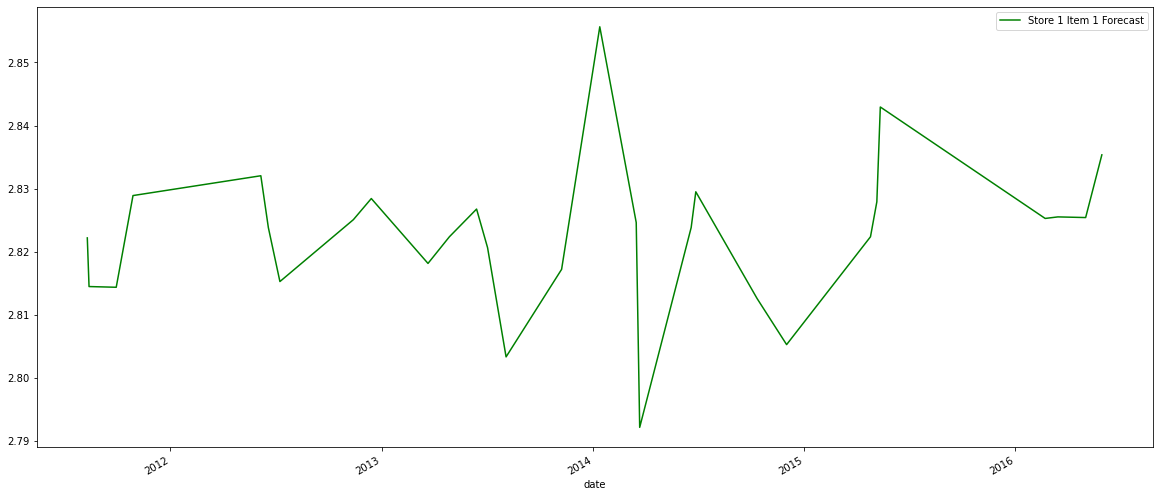

In [66]:
loaded_model = joblib.load(filename)
result = loaded_model.predict(X_test, num_iteration=model.best_iteration)
forecast = pd.DataFrame({"date":test["TRANSACTION_DATE"],
                        "store":test["STORE_ID"],
                        "item":test["BOOK_ID"],
                        "sales":test_preds
                        })

forecast[(forecast.store == 1) & (forecast.item == 121749)].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");

,STORE_ID,BOOK_ID,TRANSACTION_DATE,SALES,ID,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
6278,1,1,2014-04-16,2.079442,NaN,16,106,16,2014,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6289,1,1,2014-07-02,3.332205,NaN,2,183,27,2014,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6292,1,1,2014-07-22,3.496508,NaN,22,203,30,2014,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6304,1,1,2014-10-14,3.258097,NaN,14,287,42,2014,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6327,1,1,2015-03-21,3.367296,NaN,21,80,12,2015,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
